<a href="https://colab.research.google.com/github/YasinnSoylu/actt/blob/main/Conv2D_layers_filtiring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! pip install kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
# ! unzip skin-cancer-mnist-ham10000.zip

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from keras.optimizers import Adam , RMSprop ,SGD ,Adadelta , Adagrad , Adamax  , Nadam

from matplotlib import pyplot
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.layers import MaxPooling2D


In [3]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/', '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}      


labels = ['nv','mel','bkl','bcc',"akiec","vasc","df"]

In [4]:
skin_df = pd.read_csv(os.path.join( '/content/HAM10000_metadata.csv'))


In [5]:
skin_df['path'] = skin_df['image_id'].map(image_path.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [6]:
skin_df['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((64,64))))

In [7]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']
     

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=42)

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
     

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)
     

# Reshape image in 3 dimensions (height = 64px, width = 64px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(64,64, 3))
x_test = x_test.reshape(x_test.shape[0], *(64, 64, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(64, 64, 3))

input_shape=(64,64,3)

num_classes = 7

In [8]:
train_input_shape=(64,64,3)

In [9]:
# load vgg model
from keras.applications.vgg16 import VGG16
# load the model
model = VGG16()
# summarize the model
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue

In [11]:

# get filter weights
filters, biases = layer.get_weights()
print(layer.name, filters.shape)

predictions (4096, 1000)


In [12]:
# summarize filters in each convolutional layer
from keras.applications.vgg16 import VGG16
from matplotlib import pyplot
# load the model
model = VGG16()
# summarize filter shapes
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)


In [13]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()

In [14]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

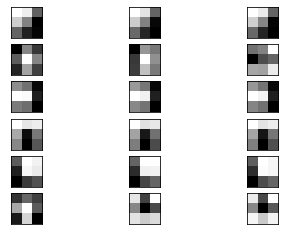

In [15]:
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

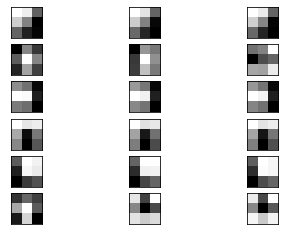

In [16]:
# cannot easily visualize filters lower down
from keras.applications.vgg16 import VGG16
from matplotlib import pyplot
# load the model
model = VGG16()
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

In [17]:
# summarize feature map size for each conv layer
from keras.applications.vgg16 import VGG16
from matplotlib import pyplot
# load the model
model = VGG16()
# summarize feature map shapes
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)


In [18]:
from tensorflow.keras import Model
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input

from numpy import expand_dims



In [19]:
model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [20]:
pth=x_train[0]

In [21]:
from keras_preprocessing.image import load_img
import cv2



In [22]:
img = test_im = x_train[1]


In [23]:
IMG_SIZ=224
img = cv2.resize(img,(IMG_SIZ,IMG_SIZ),3)

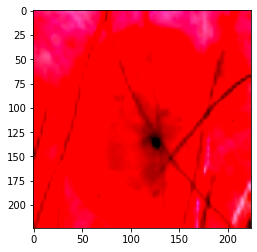

In [24]:
plt.imshow(img.reshape(224,224,3), cmap='viridis', interpolation='none')
plt.show()

In [25]:
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)

In [26]:
img = preprocess_input(img)

In [27]:
feature_maps = model.predict(img)

1/1 [==============================] - 1s 673ms/step


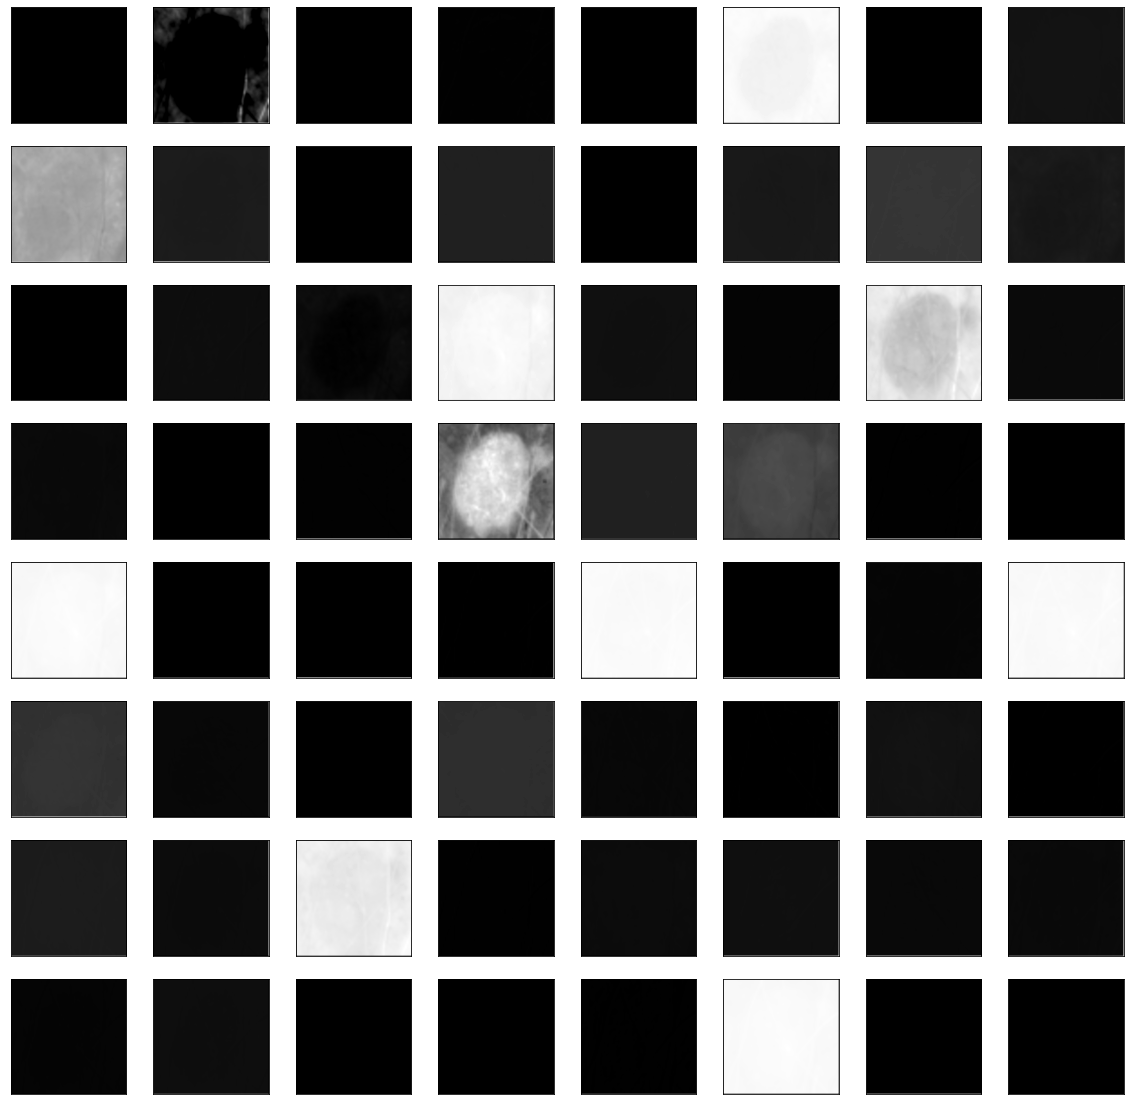

In [28]:

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

In [29]:
img = load_img('/content/lion.jpg', target_size=(224, 224))
plt.show()

In [30]:
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)

In [31]:
img = preprocess_input(img)
feature_maps = model.predict(img)

1/1 [==============================] - 0s 28ms/step


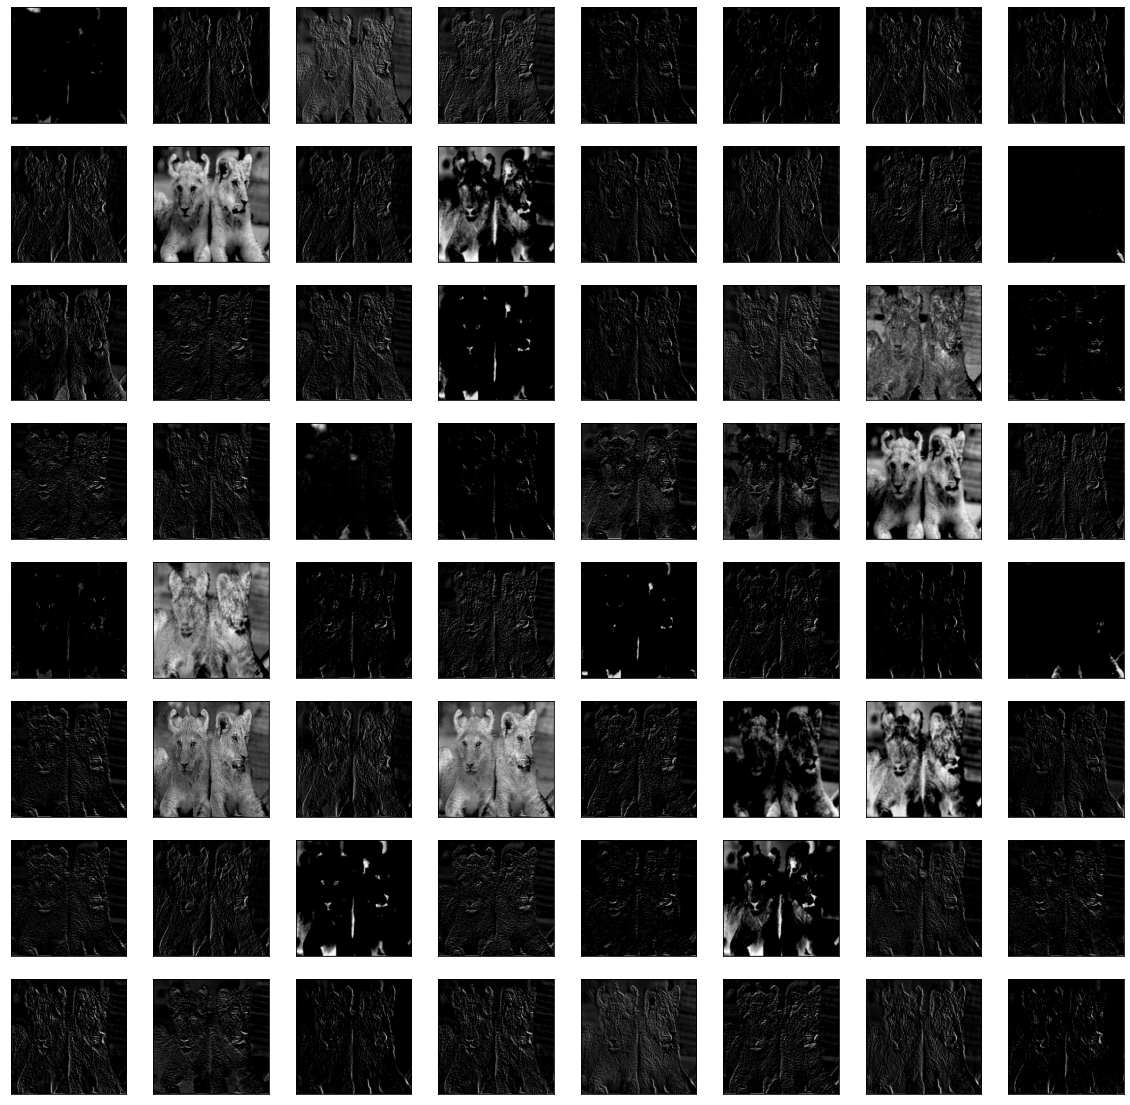

In [32]:

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-15], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

In [67]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

batch_size = 256
num_classes = 7
epochs = 10

#input image dimensions
input_shape = (64, 64,3)

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [68]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)
score = model.evaluate(x_test, y_test, verbose=0)

Epoch 1/10
29/29 [==============================] - 62s 2s/step - loss: 1.9460 - accuracy: 0.3601
Epoch 2/10
29/29 [==============================] - 60s 2s/step - loss: 1.7952 - accuracy: 0.2571
Epoch 3/10
29/29 [==============================] - 59s 2s/step - loss: 1.6775 - accuracy: 0.3490
Epoch 4/10
29/29 [==============================] - 59s 2s/step - loss: 1.4923 - accuracy: 0.5657
Epoch 5/10
29/29 [==============================] - 61s 2s/step - loss: 1.3299 - accuracy: 0.5785
Epoch 6/10
29/29 [==============================] - 63s 2s/step - loss: 1.2407 - accuracy: 0.6165
Epoch 7/10
29/29 [==============================] - 59s 2s/step - loss: 1.1701 - accuracy: 0.6408
Epoch 8/10
29/29 [==============================] - 61s 2s/step - loss: 1.1249 - accuracy: 0.6354
Epoch 9/10
29/29 [==============================] - 59s 2s/step - loss: 1.1169 - accuracy: 0.6320
Epoch 10/10
29/29 [==============================] - 59s 2s/step - loss: 1.0728 - accuracy: 0.6397


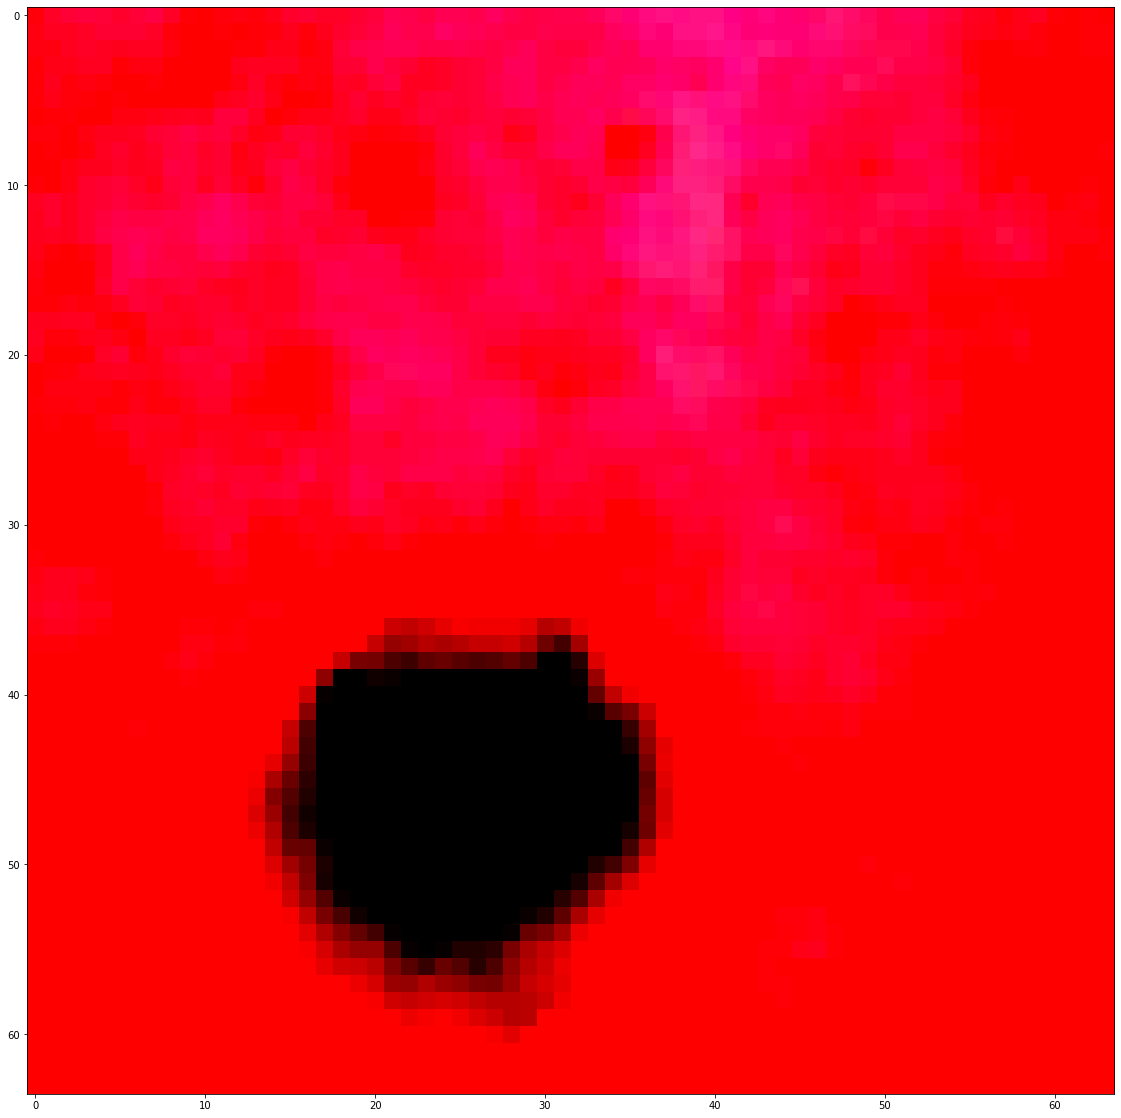

In [37]:
test_im = x_train[52]
plt.imshow(test_im.reshape(64,64,3), cmap='viridis', interpolation='none')
plt.show()

In [69]:
from tensorflow.keras import Model
import tensorflow as tf



In [70]:
from keras import models


In [71]:
layer_outputs = [layer.output for layer in model.layers[:12]] 
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # 

In [72]:
activations = activation_model.predict(test_im.reshape(1,64,64,3))


1/1 [==============================] - 0s 101ms/step


In [73]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 62, 62, 64)


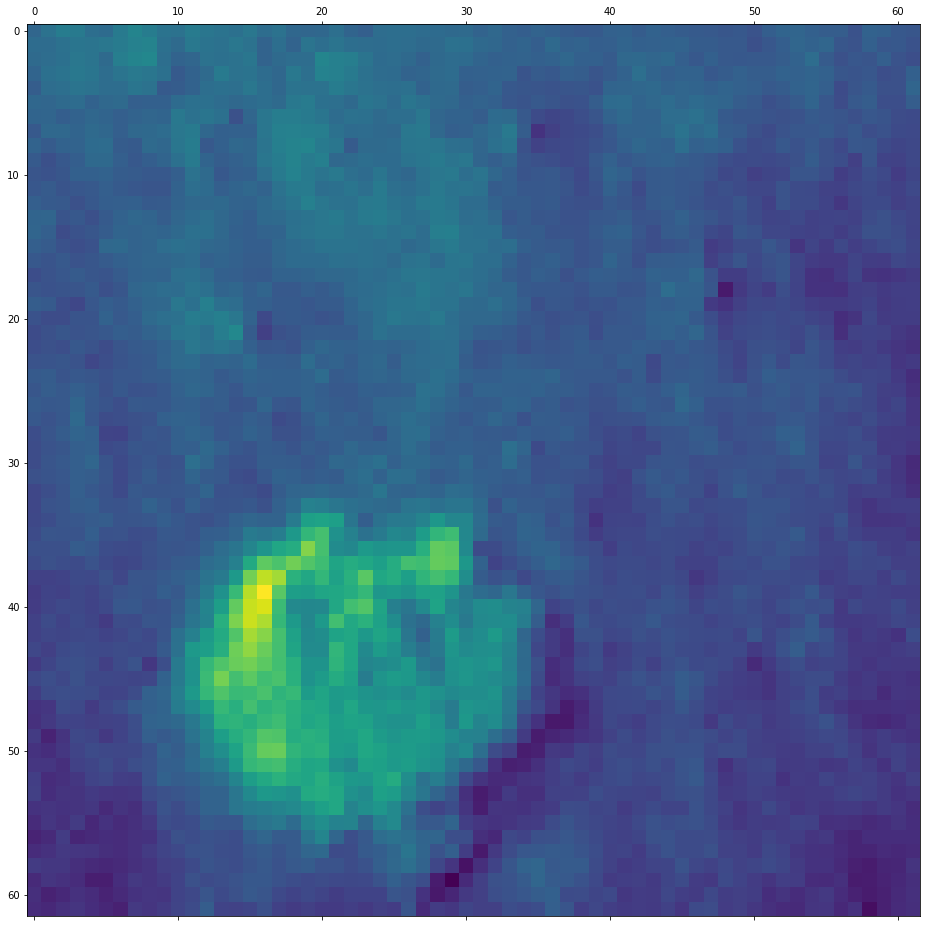

In [74]:
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4])

<ipython-input-75-235cc15cbaea>:15: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


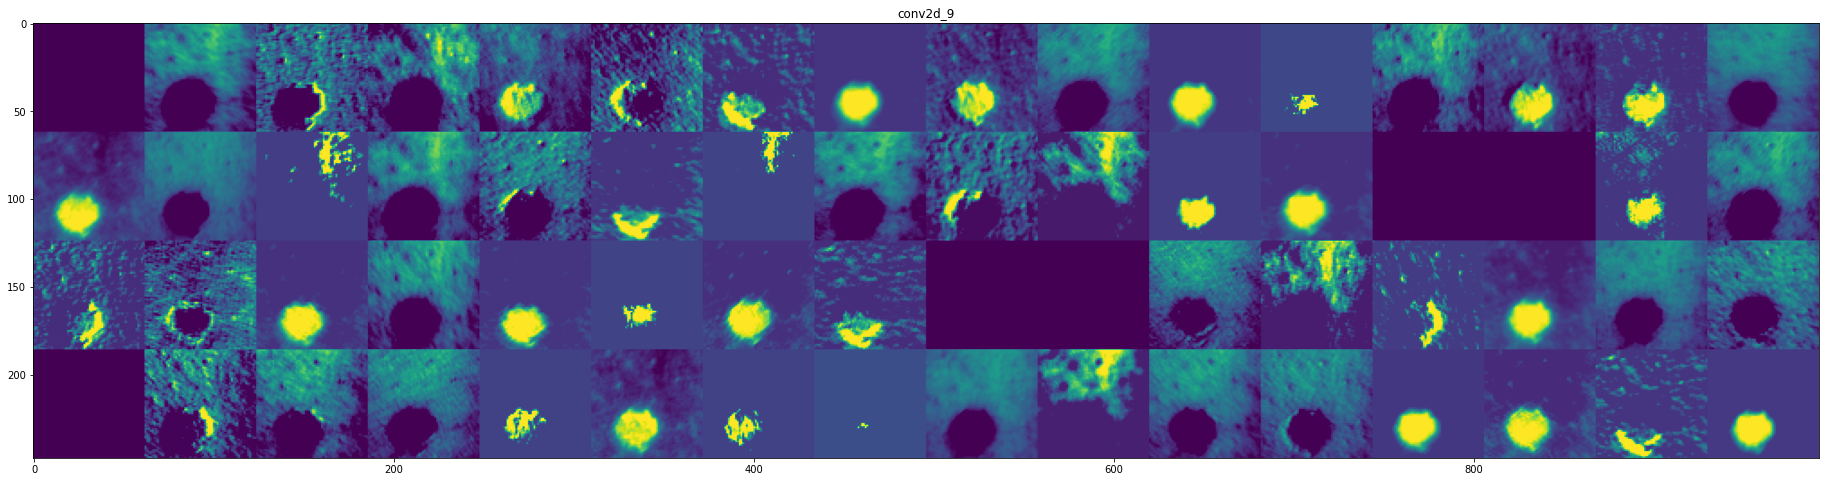

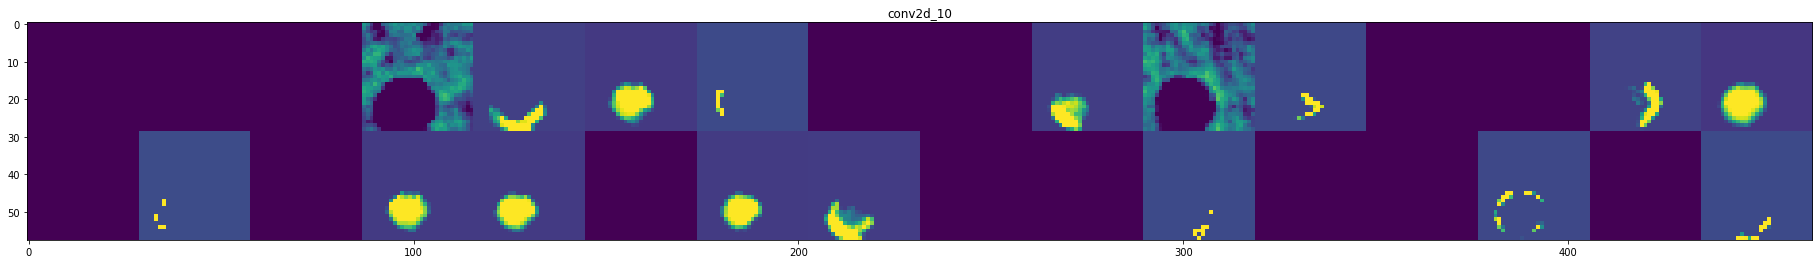

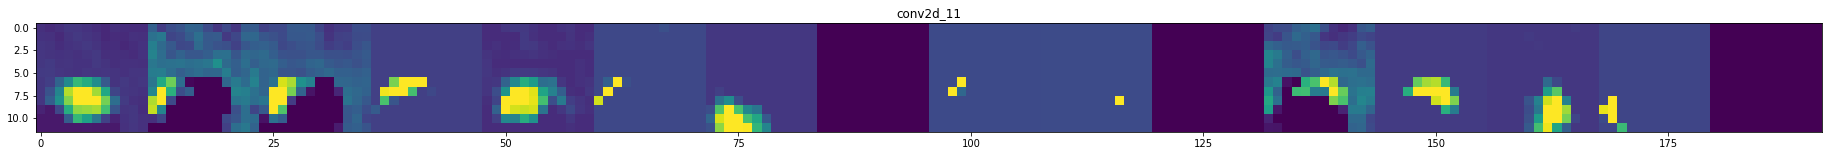

In [75]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 64
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1]*2,
                            scale * display_grid.shape[0]*2))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto')

In [76]:
image = load_img('lion.jpg', target_size=(64, 64))
img=np.asarray(image)
img.shape

(64, 64, 3)

In [77]:
layer_outputs = [layer.output for layer in model.layers[:12]] 
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # 

In [78]:
activations = activation_model.predict(img.reshape(1,64,64,3))


1/1 [==============================] - 0s 120ms/step


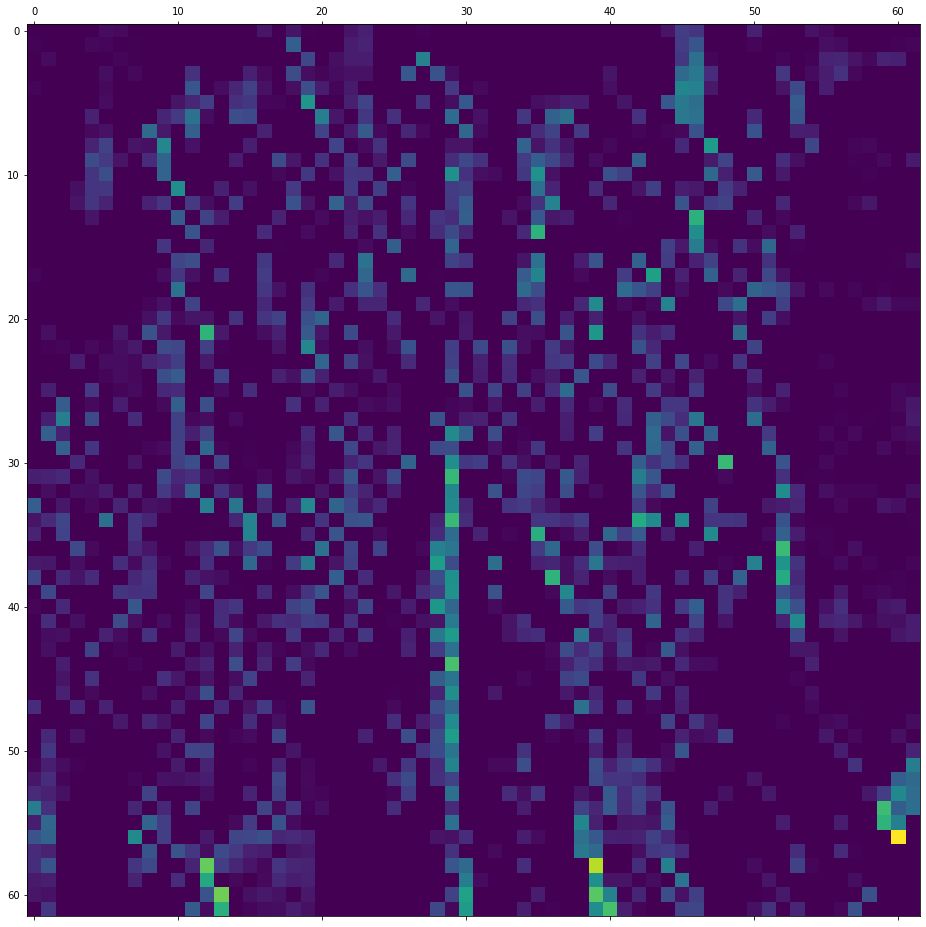

In [79]:
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4])

<ipython-input-80-235cc15cbaea>:15: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


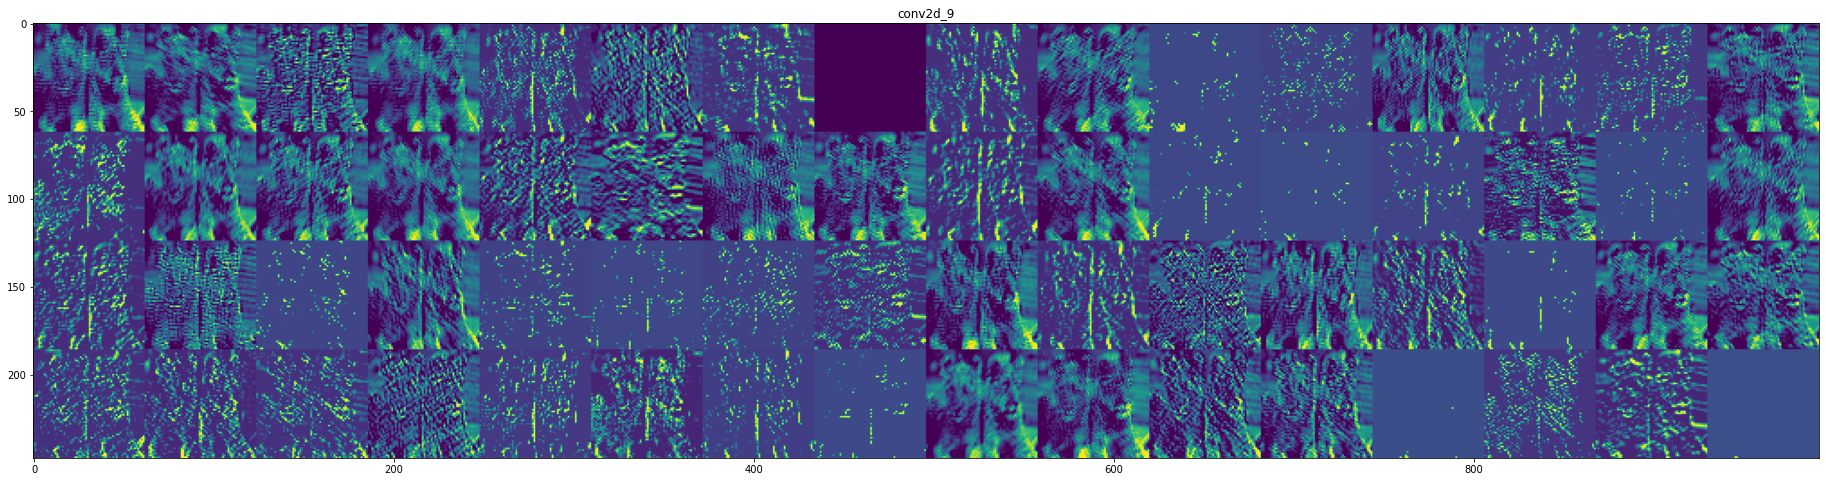

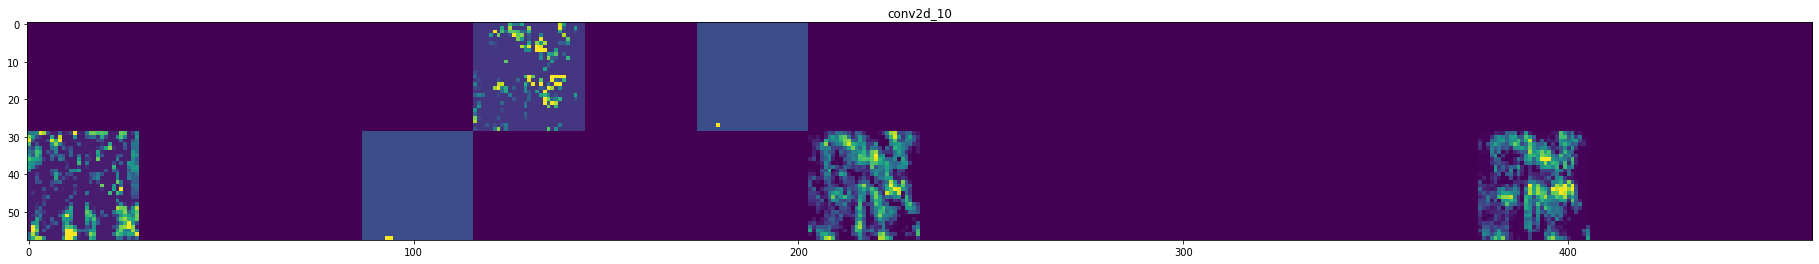

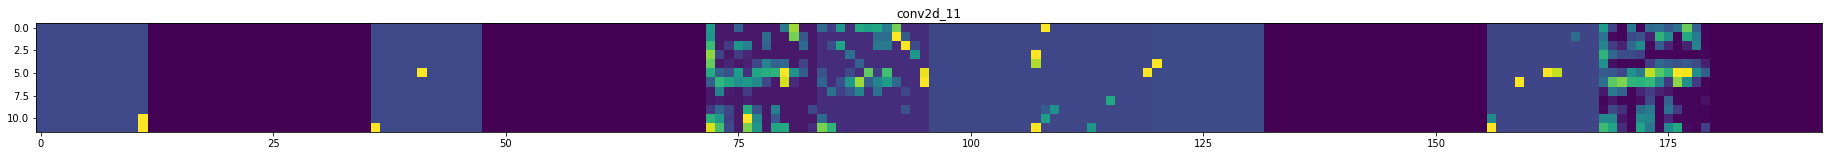

In [80]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 64
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1]*2,
                            scale * display_grid.shape[0]*2))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto')